<h1 align='center'>
    <b>
        🌾 Rice Classification by PyTorch CNN Model
    </b>
</h1>

## **Step 1 | Initial Configurations**

In [17]:
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [18]:
import warnings                               # to work with python warnings
warnings.filterwarnings('ignore')
from pathlib import Path                      # to work with path command

import matplotlib.pyplot as plt               # to visualization
import seaborn as sns

from termcolor import colored                 # to colorful output
from datetime import datetime                 # to calculate durations

import torch                                  # to work with Torch framework
import torch.nn as nn                         # to work with Neural Network
import torchvision                            # to work with image datasets
import torchvision.transforms as transforms   # to create data transforms

from sklearn.metrics import confusion_matrix, classification_report  # to evaluate the result

In [19]:
# set plots style
sns.set_style('darkgrid')

### **Step 1.3 | A test for hardware accelerator**

In [20]:
device = torch.device(
    'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(device)

cuda


## **Step 2 | Load Data and Preprocessing**

### **Step 2.1 | Load and Read Data**

In [21]:
# Set the path to the dataset
dataset_path = Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')

In [22]:
categories = [class_path.name for class_path in dataset_path.iterdir() if class_path.is_dir()]
categories

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

In [23]:
# Split dataset into 5 sets for each category in categories
karacadag = list(dataset_path.glob('Karacadag/*'))
basmati = list(dataset_path.glob('Basmati/*'))
jasmine = list(dataset_path.glob('Jasmine/*'))
arborio = list(dataset_path.glob('Arborio/*'))
ipsala = list(dataset_path.glob('Ipsala/*'))

dataset = karacadag + basmati + jasmine + arborio + ipsala

### **Step 2.2 | Visualiaze Dataset**

In [24]:
# Initialize empty lists for storing the image and labels corresponding
images, labels = [], []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
        
    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        
        # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        
        # Store the label for the image in the labels first
        labels.append(subfolder)
        
# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [25]:
df.head(3)

,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


#### Check the quantity of each type of rice:

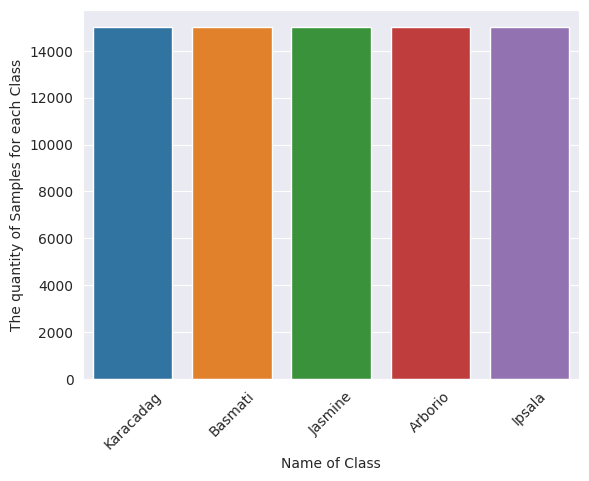

In [26]:
# Plot the classes
ax = sns.countplot(x=df.label)

# Set labels and titles
ax.set_xlabel('Name of Class')
ax.set_ylabel('The quantity of Samples for each Class')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.show()

#### Plot 4 images randomly for each classes:

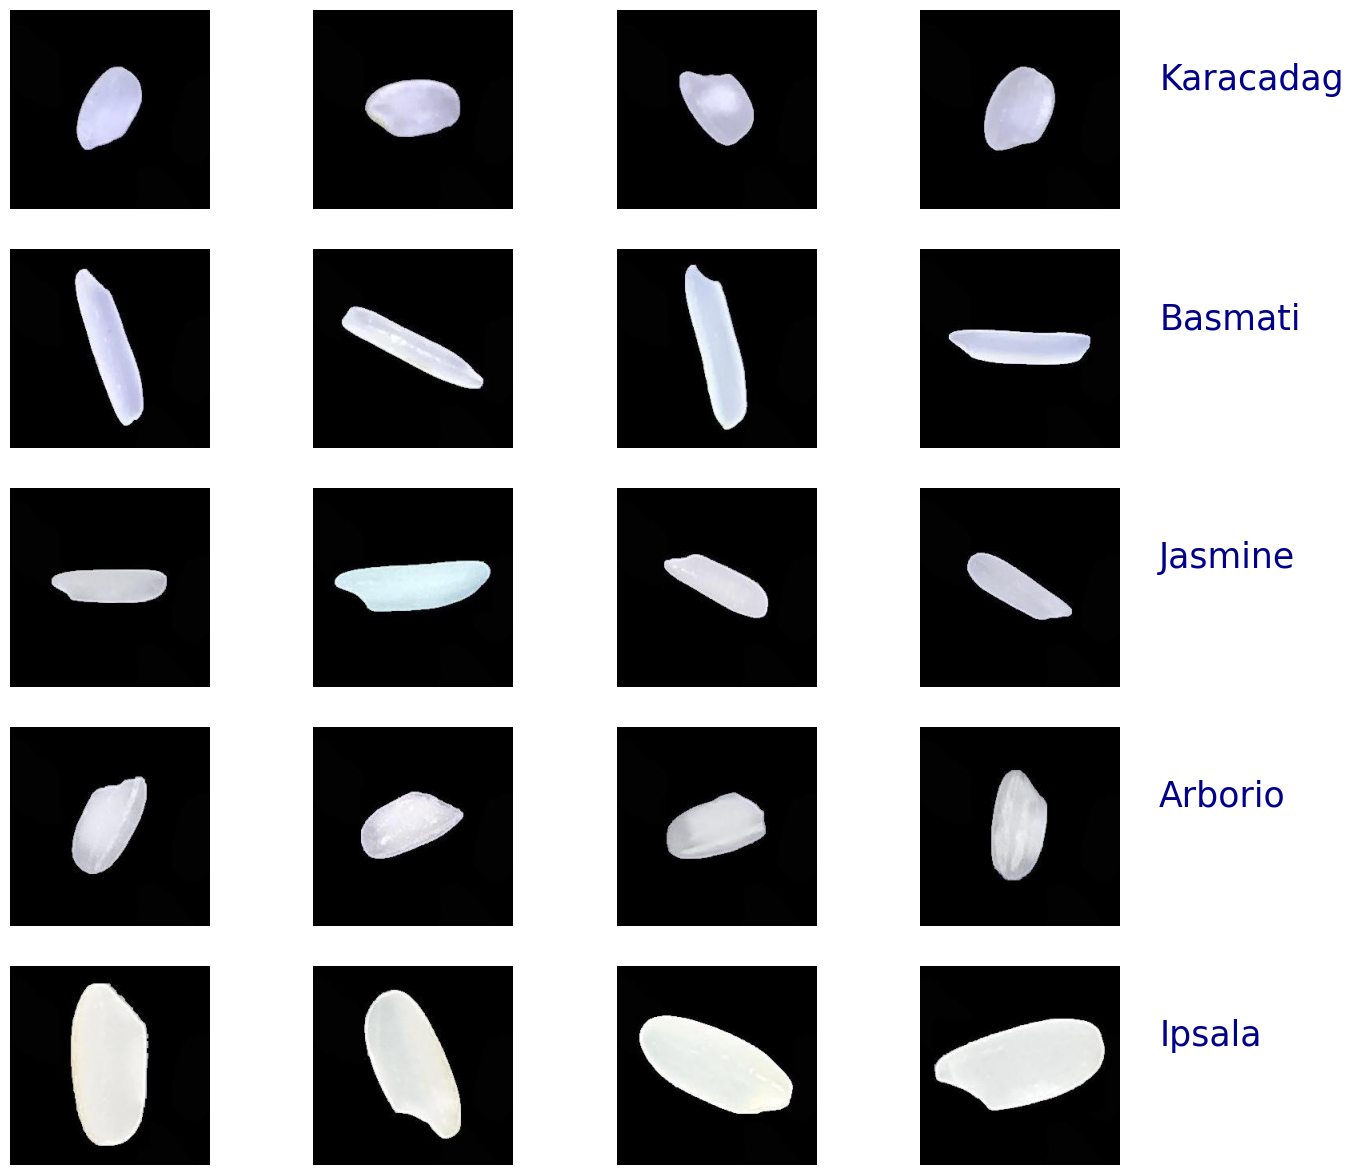

In [27]:
from matplotlib.gridspec import GridSpec

# Create figure and grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    
    # Get the filepaths for the first 4 images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    # Loop through the filepaths and add an image to each subplot
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
        
    # Add a label to the bottom of the subplot grid
    ax.text(300, 100, category, fontsize=25, color='darkblue')
    
plt.show()

### **Step 2.3 | Split Data in to Train, Validation and Test**

In [28]:
from torch.utils.data import DataLoader, random_split

# Define any necessary transformations
data_transform = transforms.Compose(
    [
        # We resize all of image to (100 x 100)
        transforms.Resize((100, 100)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.5, 0.5, 0.5],
            std = [0.5, 0.5, 0.5]
        )
    ]
)

model_dataset = torchvision.datasets.ImageFolder(dataset_path, transform=data_transform)

# Define the size of each dataset split
dataset_size = len(dataset)
train_size, val_size, test_size = (
    int(0.7 * dataset_size),
    int(0.15 * dataset_size),
    int(0.15 * dataset_size)
)

# Split the dataset
train_set, val_set, test_set = random_split(model_dataset, 
                                            (train_size, val_size, test_size))

# Create DataLoaders for each dataset
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

data_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [29]:
# Check the quantity of images in each set:
print(f'The quantity of images in Dataset: {dataset_size}')
print(f'The quantity of images in Training set: {train_size}')
print(f'The quantity of images in Validation set: {val_size}')
print(f'The quantity of images in Testing set: {test_size}')

The quantity of images in Dataset: 75000
The quantity of images in Training set: 52500
The quantity of images in Validation set: 11250
The quantity of images in Testing set: 11250


## **Step 3 | Modeling**

### **Step 3.1 | Create the Model**

In [30]:
class CNN(nn.Module):
    
    def __init__(self, num_classes):
        
        # Inheritance
        super().__init__()
        
        # Structure
        self.conv_layers = nn.Sequential(
            ### Initialize 1st set of CONV => RELU => POOL => BATCHNORM layers
            #### reduce the image shape to (H/2, W/2)
            nn.Conv2d(in_channels=3, out_channels=32, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=32),

            # Initialize 2nd set of CONV => RELU => BATCHNORM layers
            #### not change the image shape
            nn.Conv2d(in_channels=32, out_channels=64, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),

            # Initialize 3rd set of CONV => RELU => POOL => BATCHNORM layers
            #### reduce the image shape to (H/4, W/4)
            nn.Conv2d(in_channels=64, out_channels=128, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=128),
        )

        ### Dense
        self.dense_layers = nn.Sequential(
            nn.Linear(128*25*25, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

        
    def forward(self, X):
        output = self.conv_layers(X)
        output = torch.flatten(output, 1)  # flatten output into a single vector
        output = output.view(-1, 128*25*25) 
        output = self.dense_layers(output)
        return output

In [31]:
model = CNN(num_classes=5)

device = str(device)
model = model.to(device)
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=80000, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

### **Step 3.2 | Train the Model**

In [32]:
# The model's predictions match the actual labels
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    n_correct = torch.sum(out==label).item()
    n_pred = len(pred)
    return torch.tensor(n_correct / n_pred)


# The validation loss and accuracy for the 1st batch as a dictionary
def validation_step(val_loader, model, loss_function):
    for image, label in val_loader:
        y_pred = model(image)
        loss = loss_function(y_pred, label)
        acc = accuracy(y_pred, label)
        return {'val_loss': loss, 'val_acc': acc}

    
# Return the list stores the loss of the last batch in each epoch 
def fit_to_model(train_loader, val_loader, epochs, optimizer, loss_function, model):
    history = []
    
    for epoch in range(epochs):
        
        for image, label in train_loader:
            y_pred = model(image)
            loss = loss_function(y_pred, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        val = validation_step(val_loader, model, loss_function)
        
        print(f'Epoch [{epoch+1}/{epochs}] => train_loss: {loss}, val_loss: {val["val_loss"]}, val_acc: {val["val_acc"]}')
        
        history.append({
            'train_loss': loss,
            'val_loss': val["val_loss"],
            'val_acc': val["val_acc"]
        })
        
    return history

### **Step 3.3 | Training result**

In [33]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    
    def __iter__(self):
        for x in self.dataloader:
            yield to_device(x, self.device)

In [34]:
history = fit_to_model(
    train_loader = DeviceDataLoader(train_loader, device),
    val_loader = DeviceDataLoader(val_loader, device),
    epochs = 5,
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4),
    loss_function = nn.CrossEntropyLoss(),
    model = model
)

Epoch [1/5] => train_loss: 0.0038406974636018276, val_loss: 0.01037053856998682, val_acc: 1.0
Epoch [2/5] => train_loss: 0.1822541207075119, val_loss: 0.0016444703796878457, val_acc: 1.0
Epoch [3/5] => train_loss: 0.0001054218300851062, val_loss: 0.0012829945189878345, val_acc: 1.0
Epoch [4/5] => train_loss: 0.0002900206600315869, val_loss: 0.0004138104268349707, val_acc: 1.0
Epoch [5/5] => train_loss: 0.0001292969100177288, val_loss: 0.0012693781172856688, val_acc: 1.0


### **Step 3.4 | Evaluation**

In [53]:
loss_function = nn.CrossEntropyLoss()

with torch.no_grad():
    
    # Set the model in evaluation mode
    model.eval()
    
    val_loss = []
    val_correct, val_total = 0, 0
    
    # Loop over the validation set    
    for (image, label) in val_loader:
        
        # Move input data to GPU
        (image, label) = (image.to(device), label.to(device))
        
        # Forward pass
        y_pred = model(image)
        loss = loss_function(y_pred, label)
        
        # Val loss
        val_loss.append(loss.item())
        
        # Val accuracy
        val_correct += (y_pred.argmax(1) == label).type(torch.float).sum().item()
        val_total += label.shape[0]

    val_loss = np.mean(val_loss)
    val_acc = val_correct / val_total
    
    # Print the result
    print(colored(f'Loss: {val_loss:.4f}\nAccuracy: {val_acc:.4f}', 'green', attrs=['bold']))

Loss: 0.0502
Accuracy: 0.9848


## **Step 4 | Result** 

### **Step 4.1 | Visualize in Plot**

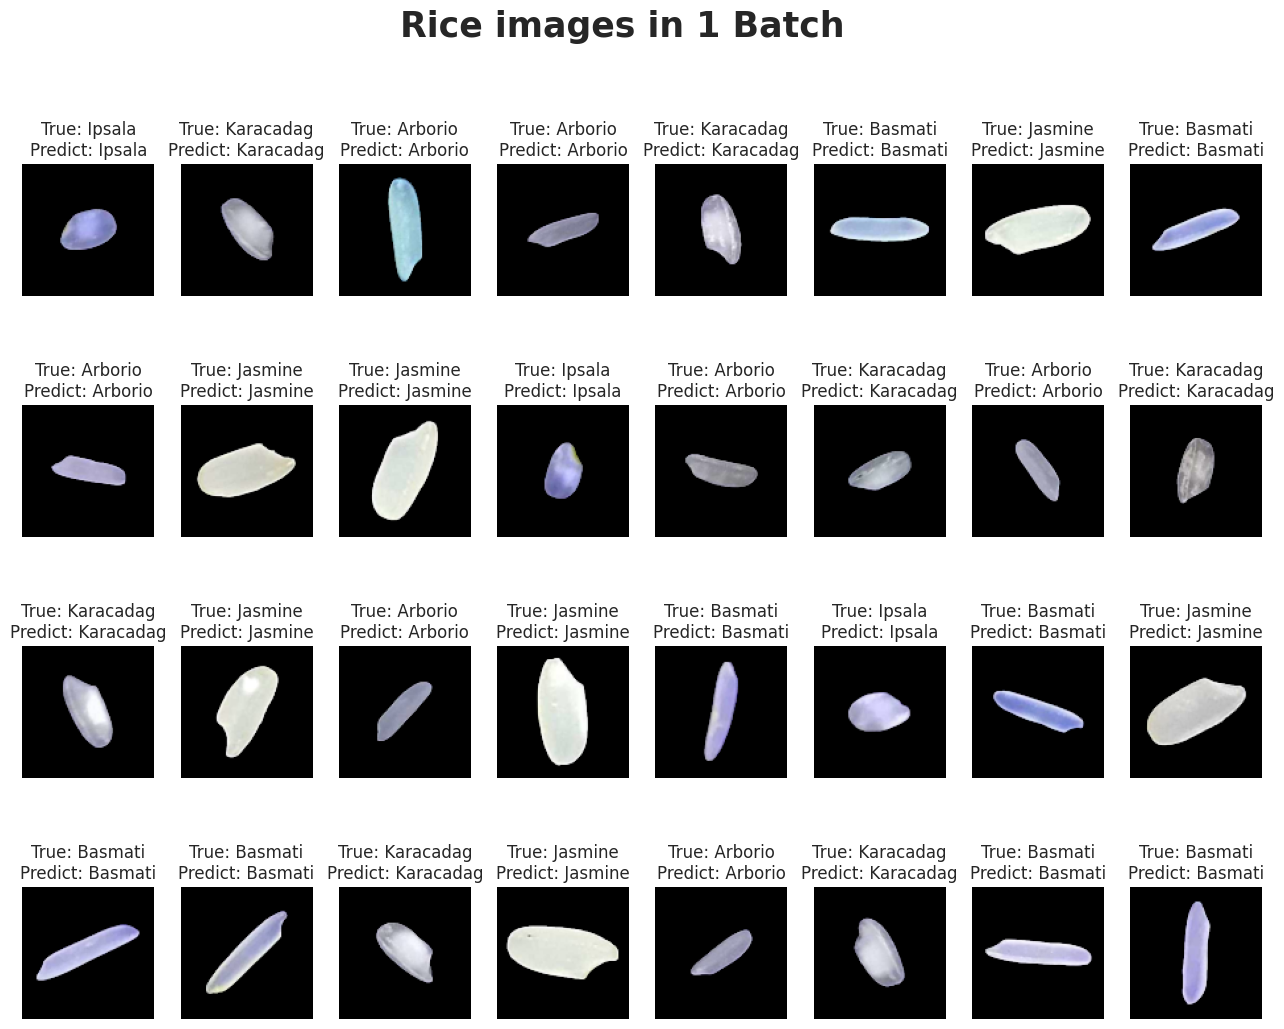

In [62]:
# Move the model to CPU
cpu_model = model.cpu()

# Get 1 batch test_loader
for images, labels in test_loader:
    break
    
# Plot 1 batch of test_loader images with True and Predicted label
plt.subplots(4, 8, figsize=(16, 12))
plt.suptitle('Rice images in 1 Batch', fontsize=25, fontweight='bold')

for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    
    img = torch.permute(images[i], (1, 2, 0))
    plt.imshow(img)
    
    label = categories[int(labels[i])]
    
    img = img[i].unsqueeze(0)
    img = images[i].unsqueeze(0)
    
    output = cpu_model(img)
    predict = categories[int(output.argmax())]
    
    plt.title(f'True: {label}\nPredict: {predict}')
    plt.axis('off')
    
plt.show()

### **Step 4.2 | Evaluation Metrics**

In [63]:
# Get out 2 lists include y_true and y_pred for use in confusion_matrix

model = model.to(device)

y_true, y_pred = [], []

for (image, label) in test_loader:
    (image, label) = (image.to(device), label.numpy())
    
    output = model(image)
    _, pred = torch.max(output.data, 1)
    pred = pred.detach().cpu().numpy()
    
    y_true = np.append(y_true, label)
    y_pred = np.append(y_pred, pred)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      2258
         1.0       1.00      0.98      0.99      2227
         2.0       1.00      1.00      1.00      2237
         3.0       0.98      1.00      0.99      2258
         4.0       1.00      0.94      0.97      2270

    accuracy                           0.98     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.98      0.98     11250



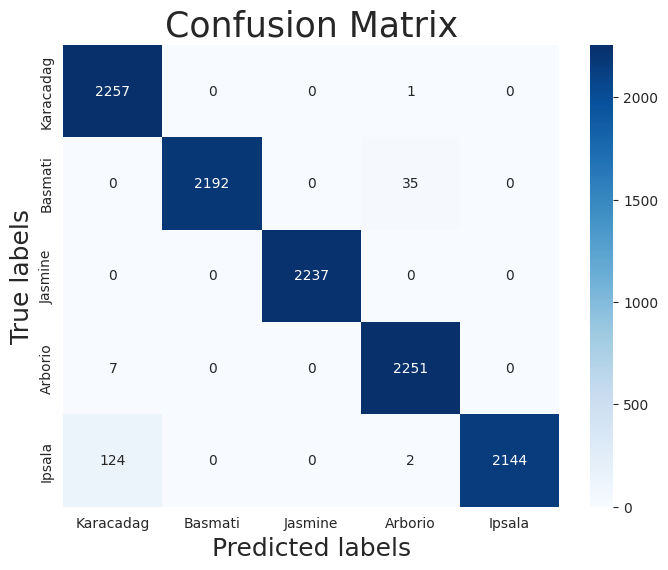

In [64]:
# Show classification_report and confusion_matrix
print(classification_report(y_true, y_pred))

def plot_confusion_matrix(y_test, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    ax = plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='', cmap='Blues')
    
    ax.set_xlabel('Predicted labels', fontsize=18)
    ax.set_ylabel('True labels', fontsize=18)
    ax.set_title('Confusion Matrix', fontsize=25)
    ax.xaxis.set_ticklabels(categories)
    ax.yaxis.set_ticklabels(categories)
    
    plt.show()
    
plot_confusion_matrix(y_true, y_pred)